# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
127119,70028200,GRADUATE SALES EXECUTIVE,GRADUATE SALES EXECUTIVE Sector: Digital Media...,City London South East,London,NaN,NaN,BMS Sales Specialists LLP,Sales Jobs,"18000 per annum + bonus, benefits",18000,salestarget.co.uk,9.798182
13548,66606331,Java Developer (FX Options) London 3 Months ...,I am currently looking for a Java Developer to...,City of London,The City,NaN,contract,NaN,IT Jobs,400 - 401 per day,96120,theitjobboard.co.uk,11.473363
59831,68691929,Technical Support Specialist / Technical Analyst,Application Support Engineer / Technical Suppo...,Cambridge Cambridgeshire East Anglia,UK,NaN,permanent,Spring Technology,IT Jobs,28000.00 - 30000.00 per annum,29000,totaljobs.com,10.275085


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,teacher of science,position : qualified teacher subject / special...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk,10.034559
244764,72705212,teacher of business studies and ict,position : qualified teacher or nqt subject / ...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk,10.034559
244765,72705213,english teacher,position : qualified teacher subject / special...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk,10.034559
244766,72705216,supply teachers,position : qualified teacher subject / special...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk,10.034559


In [7]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for row in data.iloc():
    token_counts.update(row['Title'].split(' '))
    token_counts.update(row['FullDescription'].split(' '))

In [8]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

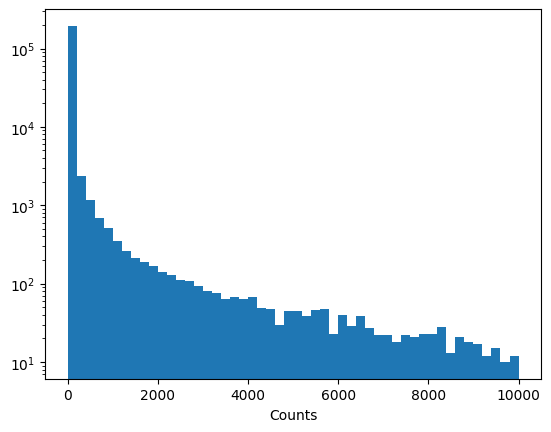

In [9]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [10]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(map(lambda item: item[0], filter(lambda item: item[1] >= min_count, token_counts.items())))

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [11]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [12]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [13]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [14]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [16]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [18]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [19]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[2380,  901,   19, 1897,  822, 1382,   14, 1664],
        [ 297,   22,  345,  901,    1,    1,    1,    1],
        [2176,  393,  130,  113,  655,   32,    1,    1]], dtype=int32),
 'FullDescription': array([[ 170,   12,   44,  434,  778, 3266,  822, 1382,   62,  105],
        [ 297,  345,  901,   22, 1040,   44, 2405, 1767,   66,  188],
        [  10,   11,   12,   44,  563,  461, 2905,  308,  337,  327]],
       dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.998843, 10.71444 , 10.389026], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [545]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda


In [546]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [547]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [548]:
class GlobalAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.sum(dim=self.dim)

In [549]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, pretrained_weights=None, is_tune=False):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        if pretrained_weights is not None:
            self.emb = nn.Embedding.from_pretrained(pretrained_weights)
            self.emb.requires_grad_(is_tune)
        else:
            self.emb = nn.Embedding(n_tokens, 300, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(300, 150, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm1d(150)
        self.conv2 = nn.Conv1d(150, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.batch1(h)
        h = self.conv2(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return h

In [550]:
title_encoder = TitleEncoder(pretrained_weights=torch.FloatTensor(embeddings.vectors))

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [551]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionsEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, pretrained_weights=None, is_tune=False):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        if pretrained_weights is not None:
            self.emb = nn.Embedding.from_pretrained(pretrained_weights)
            self.emb.requires_grad_(is_tune)
        else:
            self.emb = nn.Embedding(n_tokens, 300, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(300, 150, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm1d(150)
        self.conv2 = nn.Conv1d(150, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()  
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.batch1(h)
        h = self.conv2(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return h

In [552]:
desc_encoder = DescriptionsEncoder(pretrained_weights=torch.FloatTensor(embeddings.vectors))

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [558]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), is_tune=False, pretrained_weights=None):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=300, pretrained_weights=pretrained_weights, is_tune=is_tune).to(device)
        self.desc_encoder = DescriptionsEncoder(out_size=300, pretrained_weights=pretrained_weights, is_tune=is_tune).to(device)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(n_cat_features, 128)
        self.dense2 = nn.Linear(128, 64)
        self.batch1 = nn.BatchNorm1d(64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense3 = nn.Linear(664, 332)
        self.batch2 = nn.BatchNorm1d(332)
        self.dense4 = nn.Linear(332, 166)
        self.dense5 = nn.Linear(166, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        title_h = F.dropout(title_h, p=0.1)
        desc_h = self.desc_encoder(desc_ix)
        desc_h = F.dropout(desc_h, p=0.1)
        
        # apply categorical encoder
        cat_h = self.dense1(cat_features)
        cat_h = F.relu(cat_h)
        cat_h = self.dense2(cat_h)
        cat_h = self.batch1(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        h = self.dense3(joint_h)
        h = self.batch2(h)
        h = F.relu(h)
        h = F.dropout(h, p=0.1)
        h = self.dense4(h)
        h = self.dense5(h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return h[:, 0]

In [560]:
model = FullNetwork(pretrained_weights=torch.FloatTensor(embeddings.vectors), is_tune=True).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [561]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

prediction = model(title_ix, desc_ix, cat_features).to(device)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [562]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [563]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [564]:
model = FullNetwork(pretrained_weights=torch.FloatTensor(embeddings.vectors)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [565]:
from tqdm.notebook import trange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = trange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [566]:
num_epochs = 200
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [567]:
model.to(device)

FullNetwork(
  (title_encoder): TitleEncoder(
    (emb): Embedding(999999, 300)
    (conv1): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=(1,))
    (batch1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(150, 300, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=300, out_features=300, bias=True)
  )
  (desc_encoder): DescriptionsEncoder(
    (emb): Embedding(999999, 300)
    (conv1): Conv1d(300, 150, kernel_size=(3,), stride=(1,), padding=(1,))
    (batch1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(150, 300, kernel_size=(3,), stride=(1,), padding=(1,))
    (pool1): GlobalMaxPooling()
    (dense): Linear(in_features=300, out_features=300, bias=True)
  )
  (dense1): Linear(in_features=3768, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=64, bias=True)
  (batch1): BatchNorm1d

In [568]:
import numpy as np

best_mae = np.inf
best_epoch = 0

val_loss_list = []

for epoch_i in range(num_epochs):
    
    print(f"Training {epoch_i}:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    
    print(f"Validation {epoch_i}:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
            reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print("")
    
    if (val_mae / val_batches) < best_mae:
        torch.save(model.state_dict(), "best_model.pth")
        best_epoch = epoch_i
        best_mae = (val_mae / val_batches)
        print("New best epoch!")

    if epoch_i > best_epoch + 10:
        print("Early stop!")
        break

    val_loss_list.append(val_loss / val_batches)
    
plt.plot(range(len(val_loss_list)), val_loss_list)
ax = plt.gca()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()
model.load_state_dict(torch.load("best_model.pth"))

Training 0:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	7.19021
	MAE:	628898.31695
Validation 0:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	5.60042
	MAE:	208333.14200

New best epoch!
Training 1:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.48357
	MAE:	17501.79312
Validation 1:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	12.94548
	MAE:	722318.46773

Training 2:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	1.09642
	MAE:	12573.37054
Validation 2:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	9.67362
	MAE:	349400.55270

Training 3:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.92884
	MAE:	11826.77794
Validation 3:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.39603
	MAE:	8277.74581

New best epoch!
Training 4:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.85143
	MAE:	10420.37697
Validation 4:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.89936
	MAE:	8102.72021

New best epoch!
Training 5:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.77624
	MAE:	9346.33744
Validation 5:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.78154
	MAE:	12905.69618

Training 6:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.80748
	MAE:	12123.50794
Validation 6:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	5.76882
	MAE:	136071.23258

Training 7:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.70516
	MAE:	9062.31425
Validation 7:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.59999
	MAE:	6668.32413

New best epoch!
Training 8:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.60089
	MAE:	8213.05621
Validation 8:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	5.46094
	MAE:	124173.44458

Training 9:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.57184
	MAE:	8550.54637
Validation 9:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.77551
	MAE:	6572.24500

New best epoch!
Training 10:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.59284
	MAE:	8121.95183
Validation 10:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	5.06587
	MAE:	111383.39467

Training 11:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.55423
	MAE:	7728.22910
Validation 11:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.51966
	MAE:	9195.80757

Training 12:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.51898
	MAE:	7202.86308
Validation 12:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.61420
	MAE:	6490.65255

New best epoch!
Training 13:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.51616
	MAE:	7426.36566
Validation 13:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.42282
	MAE:	7554.43460

Training 14:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.49266
	MAE:	7247.56940
Validation 14:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.61961
	MAE:	6157.45503

New best epoch!
Training 15:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.50763
	MAE:	7518.09855
Validation 15:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.36535
	MAE:	5919.80243

New best epoch!
Training 16:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.45831
	MAE:	6993.67964
Validation 16:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35871
	MAE:	6056.57679

Training 17:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.41774
	MAE:	6532.41302
Validation 17:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.56211
	MAE:	10307.00650

Training 18:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.50181
	MAE:	7421.97748
Validation 18:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.34268
	MAE:	5471.82057

New best epoch!
Training 19:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.50386
	MAE:	7438.98516
Validation 19:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	2.58831
	MAE:	9470.98923

Training 20:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.48665
	MAE:	7431.60433
Validation 20:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.43195
	MAE:	8173.60106

Training 21:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.40334
	MAE:	6637.60173
Validation 21:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	1.14653
	MAE:	20501.98436

Training 22:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.43612
	MAE:	6890.85263
Validation 22:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	5.10462
	MAE:	10993.25379

Training 23:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.40794
	MAE:	6462.15354
Validation 23:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.33704
	MAE:	5755.49420

Training 24:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.39743
	MAE:	6406.36969
Validation 24:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.30208
	MAE:	5762.05672

Training 25:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.37307
	MAE:	6124.74368
Validation 25:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.30740
	MAE:	5090.99257

New best epoch!
Training 26:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.41331
	MAE:	6659.15376
Validation 26:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.31166
	MAE:	5657.44185

Training 27:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.40553
	MAE:	6607.05696
Validation 27:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.33883
	MAE:	5066.81282

New best epoch!
Training 28:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.39113
	MAE:	6369.10134
Validation 28:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.29951
	MAE:	5908.38836

Training 29:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.34691
	MAE:	5893.69483
Validation 29:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.33263
	MAE:	6800.60766

Training 30:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.36178
	MAE:	6016.44623
Validation 30:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35545
	MAE:	7206.12220

Training 31:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.33407
	MAE:	5842.49643
Validation 31:


  0%|          | 0/765 [00:00<?, ?it/s]

In [ ]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"])).to(device)
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).to(device)
        cat_features = Variable(torch.FloatTensor(batch["Categorical"])).to(device)
        reference = Variable(torch.FloatTensor(batch[target_column])).to(device)

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08315
	MAE:	2735.82698





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.


## Improvement of base model
Base model _MAE_: 3279.18025. 
1. First of all, let's do our training more efficient and more fast. We will stop if MAE don't improve for 10 epoch and use model from best epoch and raw loss curve.
Also let's transfer our learning to GPU this will make it more fast and we will faster see further improvement. Model MAE after 1 step: 2659.21828.
2. Some dropout and batches give MAE 3612.81334
3. Implement AvgPooling, add it to TitleEmbeddings and DescriptionEmbedding MAE: 35758.90582
4. Use gensim model `glove-wiki-gigaword-300` for pretraining embedding and also add more conv layers and change size for model working. MAE: 5066.81282

Last step should learn really long, so i stop it after 30 epoch with MAE above. Also there are option for tuning pretrained weights, but it learn twice longer so i didn't manage to create appropriate run.
From my tests i manage to create base model with early stop with MAE 2659.21828, other approaches wasn't so successful. But may be with longer learning stage can give something good.